In [1]:
from hftbacktest import NONE, NEW, HftBacktest, GTX, FeedLatency, SquareProbQueueModel, BUY, SELL, Linear, Stat, reset
from numba import njit
from numba.typed import Dict
import numpy as np

In [2]:
@njit
def grid_trading_reservation_price(hbt, stat):
    grid_interval = hbt.tick_size * 10
    grid_num = 20
    half_spread = hbt.tick_size * 20
    skew = 1
    
    order_qty = 0.01
    max_position = 10
        
    while hbt.elapse(100_000):
        hbt.clear_inactive_orders()

        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        reservation_price = mid_price - skew * hbt.position * hbt.tick_size
        bid_price = np.floor((reservation_price - half_spread) / grid_interval) * grid_interval
        ask_price = np.ceil((reservation_price + half_spread) / grid_interval) * grid_interval
        
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)      
            
        stat.record(hbt)
    return True

In [3]:
file_name = 'btcusdt_20230615'
eod_file_name = 'btcusdt_20230614'

hbt = HftBacktest(
    [
        f'./data/{file_name}.npz'
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    snapshot=f'./data/{eod_file_name}_eod.npz'
)

stat = Stat(hbt)

Load ./data/btcusdt_20230615.npz


In [4]:
grid_trading_reservation_price(hbt, stat.recorder)

True

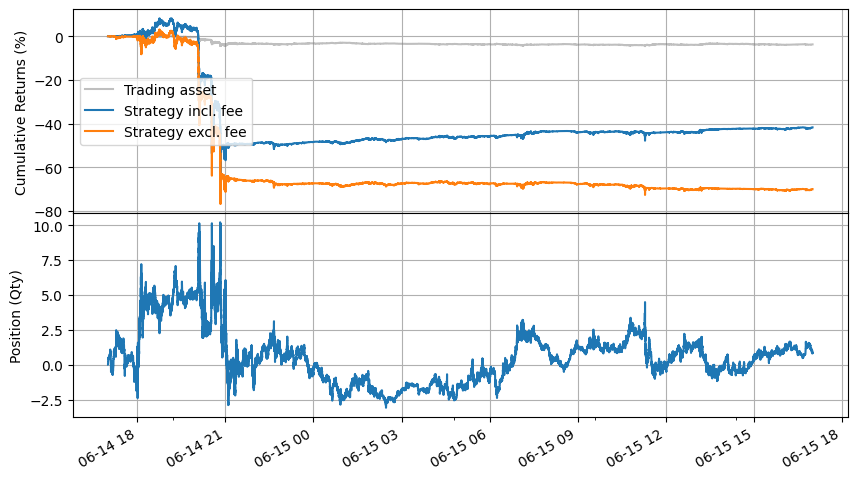

In [5]:
stat.save_summary_to_file(capital=10_000, trading_days=1, name=f'origin_{file_name}')